In [1]:
!pip install lightgbm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import lightgbm as gbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [4]:
#store = pd.HDFStore('X_pca.h5')
#X_pca = store['X_pca']

store = pd.HDFStore('X_frac.h5')
X = store['X_frac']

store = pd.HDFStore('X_frac_mob.h5')
X_mob = store['X_frac_mob']

store = pd.HDFStore('X_frac_month.h5')
X_month = store['X_frac_month']

store = pd.HDFStore('X_frac_year.h5')
X_year = store['X_frac_year']

store = pd.HDFStore('y_frac_default.h5')
y_default = store['y_frac_default']

store = pd.HDFStore('y_frac_prepay.h5')
y_prepay = store['y_frac_prepay']

X = X.join(X_mob)
X = X.join(X_month)
X = X.join(X_year)

In [5]:
X

,loan_amount,monthly_payment,grade,income,inq_last_6m,num_open_accts,revol_bal,num_tot_accts,tot_credit_bal,accts_opn_last_6m,...,fico,util_rate,loan_over_income,term,dti,platform_id,post_dti,mob,Orig_month,Orig_year
0,19200.0,457.28,3,60000.0000,0.745387,17.000000,5057.000000,22.000000,17039.000000,1.000000,...,707.0,14.200000,0.320000,60,0.172900,0,0.264354,9,1,2018
1,9500.0,308.42,2,56000.0000,1.000000,8.000000,427.000000,23.000000,28382.000000,2.000000,...,707.0,21.400000,0.170000,36,0.225400,0,0.291489,10,12,2017
2,15000.0,465.50,0,140000.0000,0.745387,9.000000,28695.000000,18.000000,55504.000000,29.927927,...,722.0,82.500000,0.110000,36,0.134800,0,0.174700,1,2,2018
3,19200.0,524.30,4,82000.0000,0.745387,19.000000,15882.000000,29.000000,39287.000000,1.000000,...,672.0,41.900000,0.230000,60,0.206200,0,0.282926,9,1,2018
4,10000.0,324.61,2,65000.0000,1.000000,8.000000,1356.000000,20.000000,4143.000000,1.000000,...,682.0,7.900000,0.150000,36,0.106400,0,0.166327,20,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10381408,25000.0,584.95,3,60000.0000,0.745387,15.000000,7919.000000,28.000000,255.000000,29.927927,...,670.0,45.000000,0.416667,60,0.233012,2,0.350000,23,6,2017
10381409,3150.0,94.85,1,156000.0000,0.745387,1.000000,3353.000000,3.000000,194476.000000,29.927927,...,830.0,5.000000,0.020192,36,0.002704,2,0.010000,9,6,2018
10381410,32000.0,699.75,2,69999.9996,0.745387,11.074699,14571.576638,21.478623,133845.268705,29.927927,...,750.0,46.936703,0.457143,60,0.110045,2,0.230000,44,1,2016
10381411,6000.0,180.69,1,39999.9996,0.745387,11.074699,14571.576638,21.478623,133845.268705,29.927927,...,790.0,46.936703,0.150000,36,0.065794,2,0.120000,3,12,2016


In [4]:
trainX, testX, trainy, testy = train_test_split(X, y_default, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

No Skill: ROC AUC=0.500
LGBMClassifier: ROC AUC=0.782


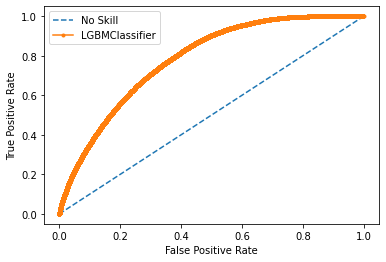

56.916688442230225 s


In [5]:
time_start = time.time()
model = gbm.LGBMClassifier(max_depth= 6, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

# save the model to disk
filename = 'lgbm_model_default.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))


# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBMClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LGBMClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")

In [6]:
trainX, testX, trainy, testy = train_test_split(X, y_prepay, test_size=0.2, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

No Skill: ROC AUC=0.500
LGBMClassifier: ROC AUC=0.658


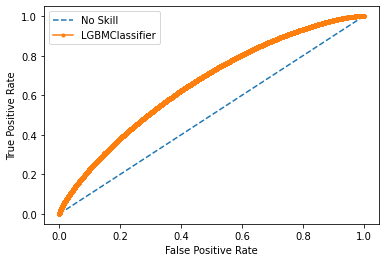

62.293039321899414 s


In [7]:
time_start = time.time()
model = gbm.LGBMClassifier(max_depth= 6, n_estimators=100)
model.fit(trainX, trainy)
time_end = time.time()

filename = 'lgbm_model_prepay.sav'
#filename = 'xgb_model_date_prepay.sav'

pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LGBMClassifier: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LGBMClassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print (time_end - time_start, "s")